In [ ]:
import genus

In [1]:
from genus.util import convert_to_box_list, invert_convert_to_box_list
from genus.util import compute_ranking, compute_average_in_box
import torch
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:

img_train, seg_mask_train, count_train = load_obj("./data_train.pt")
img_test, seg_mask_test, count_test = load_obj("./data_test.pt")
img_test_out, seg_mask_test_out, count_test_out = load_obj("./ground_truth")



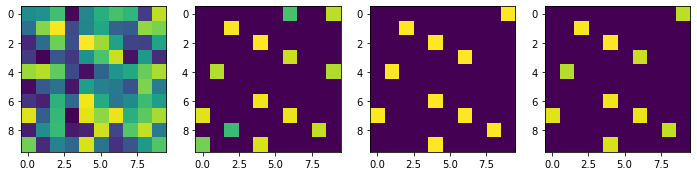

In [5]:
### av_intensity_nb = compute_average_in_box((imgs_bcwh - out_background_bcwh).abs(), bounding_box_nb)
w_raw, h_raw = 10,10
k_objects_max = 10

# Compute the ranking
av_intensity_nb = torch.randn((w_raw*h_raw,2))
ranking_nb = compute_ranking(av_intensity_nb)  # It is in [0,n-1]
tmp_nb = (ranking_nb + 1).float() / (ranking_nb.shape[-2]+1)  # strictly inside (0,1) range
tmp_b1wh = invert_convert_to_box_list(tmp_nb.unsqueeze(-1),
                                      original_width=w_raw,
                                      original_height=h_raw)

# Extract the local-maxima from the ranking
tmp_pooled_b1wh = F.max_pool2d(tmp_b1wh, kernel_size=3, stride=1, padding=1, return_indices=False)
local_maxima_mask_b1wh = (tmp_pooled_b1wh == tmp_b1wh)

# Now select the top k local maxima
score_b1wh = local_maxima_mask_b1wh * tmp_b1wh
score_nb = convert_to_box_list(score_b1wh).squeeze(-1)
index_kb = torch.topk(score_nb, k=k_objects_max, dim=-2, largest=True, sorted=True)[1]
k_local_maxima_mask_nb = torch.zeros_like(score_nb).scatter(dim=-2, index=index_kb, src=torch.ones_like(score_nb))
k_local_maxima_mask_b1wh = invert_convert_to_box_list(k_local_maxima_mask_nb.unsqueeze(-1),
                                                      original_width=w_raw,
                                                      original_height=h_raw)


fig, axes = plt.subplots(ncols=4, figsize=(12,12))
axes[0].imshow(tmp_b1wh[0,0])
axes[1].imshow(score_b1wh[0,0])
axes[2].imshow(k_local_maxima_mask_b1wh[0,0])
axes[3].imshow((k_local_maxima_mask_b1wh*score_b1wh)[0,0])

In [ ]:
value_local_maxima_b1wh = (local_maxima_mask_b1wh * tmp_b1wh)
print("DEBUG value_local_maxima_b1wh[0,0].sum()", value_local_maxima_b1wh[0,0])
value_local_maxima_nb = convert_to_box_list(value_local_maxima_b1wh).squeeze(-1)
print("DEBUG value_local_maxima_nb[:,0]",value_local_maxima_nb[:,0])
values_kb, index_kb = torch.topk(value_local_maxima_nb, k=k_objects_max, dim=-2,
                                 largest=True, sorted=True)

                
                

In [ ]:
print("AUCH  auch ---------", value_local_maxima_nb[index_kb[:,0],0])
print("DEBUG values_kb[:,0]",values_kb[:,0])
print("DEBUG index_kb[:,0]",index_kb[:,0])
print("DEBUG value_local_maxima_nb[:,0]", value_local_maxima_nb[:,0])
# Exactly k_objects_max are non_zero with values in (0.1, 0.9) the other elements are zero.



p_target_nb = torch.zeros_like(value_local_maxima_nb).scatter(dim=0,
                                                              index=index_kb,
                                                              src=value_local_maxima_nb)
print("DEBUG p_target_nb[:,0]",p_target_nb[:,0])

In [ ]:
                
                
ranking_nb = compute_ranking(av_intensity_nb)  # It is in [0,n-1]
tmp_nb = (ranking_nb + 1).float() / (ranking_nb.shape[-2]+1)  # strictly inside (0,1) range
tmp_b1wh = invert_convert_to_box_list(tmp_nb.unsqueeze(-1),
                                      original_width=w_raw,
                                      original_height=h_raw)

# Extract exactly the k largest local maxima from the ranking
tmp_pooled_b1wh = F.max_pool2d(tmp_b1wh, kernel_size=3, stride=1, padding=1, return_indices=False)
local_maxima_mask_b1wh = (tmp_pooled_b1wh == tmp_b1wh)
value_local_maxima_b1wh = (local_maxima_mask_b1wh * tmp_b1wh)
value_local_maxima_nb = convert_to_box_list(value_local_maxima_b1wh).squeeze(-1)
index_kb = torch.topk(value_local_maxima_nb, k=k_objects_max, dim=-2, largest=True, sorted=True)[1]

p_target_nb = torch.zeros_like(value_local_maxima_nb).scatter(dim=0,
                                                              index=index_kb,
                                                              src=value_local_maxima_nb.clamp(min=0.1))
p_target_b1wh = invert_convert_to_box_list(p_target_nb.unsqueeze(-1),
                                           original_width=w_raw,
                                           original_height=h_raw)
p_corr_b1wh = p_target_b1wh

In [ ]:
print(p_corr_b1wh.shape)

plt.imshow(p_corr_b1wh[0,0])

In [ ]:
import torch

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
b, w, h = 2, 20,20
p_v1 = torch.rand((b,1,w,h))
print(torch.min(p_v1), torch.max(p_v1))
logit = torch.log(p_v1) - torch.log1p(-p_v1)
p_v2 = torch.sigmoid(logit)
delta_p = p_v2 - p_v1
print(torch.min(delta_p), torch.max(delta_p))


plt.imshow(delta_p[0,0])

In [ ]:
torch.sigmoid(torch.tensor(-16.0))

In [ ]:
import genus
from genus.cropper_uncropper import Uncropper
from genus.non_max_suppression import NonMaxSuppression
from genus.namedtuple import BB
import torch

In [ ]:
k, b = 4, 1
small_squares = torch.ones(k,b,1,28,28)
bx = torch.tensor((20,20,40,60), dtype=torch.float)[..., None]
by = torch.tensor((20,60,20,60), dtype=torch.float)[..., None]
bw = torch.tensor((10,20,20,20), dtype=torch.float)[..., None]
bh = torch.tensor((5,5,5,5), dtype=torch.float)[..., None]

bounding_box = BB(bx,by,bw,bh)

uncropper = Uncropper()

mixing = uncropper.uncrop(bounding_box, small_squares, width_big=80, height_big=80)
mixing[0] *= 0.2
print(mixing.shape)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(mixing[0,0,0])

In [ ]:
tmp = torch.sum(mixing, dim=0)
print(tmp.shape)
plt.imshow(tmp[0,0])

In [ ]:
def optimal_bb_and_bb_regression_penalty(mixing_kb1wh: torch.Tensor,
                                         bounding_boxes_kb: BB,
                                         pad_size: int,
                                         min_box_size: float,
                                         max_box_size: float) -> (BB, torch.Tensor):
    
    with torch.no_grad():

        # Compute the ideal Bounding boxes
        mask_kbwh = (mixing_kb1wh.squeeze(-3) > 0.5).int()
        mask_kbh = torch.max(mask_kbwh, dim=-2)[0]
        mask_kbw = torch.max(mask_kbwh, dim=-1)[0]
        mask_kb = torch.max(mask_kbw, dim=-1)[0]  # 0 if empty, 1 if non-empty

        plus_h = torch.arange(start=0, end=mask_kbh.shape[-1], step=1, dtype=torch.float, device=mixing_kb1wh.device) + 1
        plus_w = torch.arange(start=0, end=mask_kbw.shape[-1], step=1, dtype=torch.float, device=mixing_kb1wh.device) + 1
        minus_h = plus_h[-1] - plus_h + 1
        minus_w = plus_w[-1] - plus_w + 1

        # Find the coordinates of the bounding box
        ideal_x3_kb = (torch.argmax(mask_kbw * plus_w,  dim=-1) + pad_size).clamp(min=0, max=mask_kbw.shape[-1]).float()
        ideal_x1_kb = (torch.argmax(mask_kbw * minus_w, dim=-1) - pad_size).clamp(min=0, max=mask_kbw.shape[-1]).float()
        ideal_y3_kb = (torch.argmax(mask_kbh * plus_h,  dim=-1) + pad_size).clamp(min=0, max=mask_kbh.shape[-1]).float()
        ideal_y1_kb = (torch.argmax(mask_kbh * minus_h, dim=-1) - pad_size).clamp(min=0, max=mask_kbh.shape[-1]).float()

        # If the box is empty, do a special treatment
        empty_kb = (mask_kb == 0)
        ideal_x3_kb[empty_kb] = bounding_boxes_kb.bx[empty_kb] + 0.5 * min_box_size
        ideal_x1_kb[empty_kb] = bounding_boxes_kb.bx[empty_kb] - 0.5 * min_box_size
        ideal_y3_kb[empty_kb] = bounding_boxes_kb.by[empty_kb] + 0.5 * min_box_size
        ideal_y1_kb[empty_kb] = bounding_boxes_kb.by[empty_kb] - 0.5 * min_box_size

        # Compute the box coordinates
        ideal_bx_kb = 0.5*(ideal_x3_kb + ideal_x1_kb)
        ideal_by_kb = 0.5*(ideal_y3_kb + ideal_y1_kb)
        ideal_bw_kb = (ideal_x3_kb - ideal_x1_kb).clamp(min=min_box_size, max=max_box_size)
        ideal_bh_kb = (ideal_y3_kb - ideal_y1_kb).clamp(min=min_box_size, max=max_box_size)

        # Now compute the regression cost
        x3_tmp_kb = ideal_bx_kb + 0.5 * ideal_bw_kb
        x1_tmp_kb = ideal_bx_kb - 0.5 * ideal_bw_kb
        y3_tmp_kb = ideal_by_kb + 0.5 * ideal_bh_kb
        y1_tmp_kb = ideal_by_kb - 0.5 * ideal_bh_kb

        bw_target_kb = torch.max(x3_tmp_kb - bounding_boxes_kb.bx,
                                 bounding_boxes_kb.bx - x1_tmp_kb).clamp(min=min_box_size, max=max_box_size)
        bh_target_kb = torch.max(y3_tmp_kb - bounding_boxes_kb.bw,
                                 bounding_boxes_kb.bw - y1_tmp_kb).clamp(min=min_box_size, max=max_box_size)

    # this is the only part outside the torch.no_grad()
    cost_bb_regression = ((bw_target_kb - bounding_boxes_kb.bw)/min_box_size).pow(2) + \
                         ((bh_target_kb - bounding_boxes_kb.bh)/min_box_size).pow(2)

    return BB(bx=ideal_bx_kb, by=ideal_by_kb, bw=ideal_bw_kb, bh=ideal_bh_kb), cost_bb_regression

In [ ]:
new_bb, cost = optimal_bb_and_bb_regression_penalty(mixing, 
                                                    bounding_box, 
                                                    pad_size=2, 
                                                    min_box_size=5,
                                                    max_box_size=35)

In [ ]:
print(new_bb.bx.view(-1), bounding_box.bx.view(-1))
print(new_bb.by.view(-1), bounding_box.by.view(-1))
print(new_bb.bw.view(-1), bounding_box.bw.view(-1))
print(new_bb.bh.view(-1), bounding_box.bh.view(-1))

In [ ]:
new_mixing = uncropper.uncrop(new_bb, small_squares, width_big=80, height_big=80)
print(new_mixing.shape)

In [ ]:
plt.imshow(new_mixing[0,0,0])

In [ ]:
new_tmp = torch.sum(new_mixing, dim=0)
print(new_tmp.shape)
plt.imshow(new_tmp[0,0])

In [ ]:
import numpy

In [ ]:
numpy.exp(0.2)

In [ ]:
def KL(x,y):
    return x*torch.log(x/y)+(1-x)*torch.log((1-x)/(1-y))
    
x = torch.linspace(0.01,0.99,100).view(-1,1)
y = torch.linspace(0.01,0.99,100).view(1,-1)

z = KL(x,y)
    

In [ ]:
plt.imshow(z)